# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



Домашнее задание Комаровой АВ.

### Установка зависимостей

In [2]:
!pip install wheel==0.34.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: wheel
    Found existing installation: wheel 0.38.4
    Uninstalling wheel-0.38.4:
      Successfully uninstalled wheel-0.38.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
prophet 1.1.1 requires wheel>=0.37.0, but you have wheel 0.34.1 which is incompatible.


In [3]:
# установка подходящей версии torch

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

#!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [4]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [5]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [6]:
!unzip -q /content/gdrive/My\ Drive/Simpsons_kaggle/train.zip -d train
!unzip -q /content/gdrive/My\ Drive/Simpsons_kaggle/testset.zip -d test

In [7]:
!ls train

train


In [8]:
!ls test

testset


In [9]:
!nvidia-smi
torch.cuda.is_available()

Tue Nov 29 21:24:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    10W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [10]:
import numpy as np
import pandas as pd

import pickle
import PIL
print(PIL.PILLOW_VERSION)

from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
import torch.nn.functional as F

from torchvision import datasets, transforms, models
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler
import torch.nn as nn
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: PILLOW_VERSION is deprecated and will be removed in a future release. Use __version__ instead.
  


7.1.2


In [11]:
SEED = 261122
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

In [12]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
BATCH_SIZE = 64
N_CORES = 2
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [13]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)    
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode == "train":  
            
            augmentations = transforms.RandomChoice([
                                   transforms.Compose([
                                       transforms.Resize(size=313, max_size=333),
                                       transforms.CenterCrop(size=300),
                                       transforms.RandomCrop(250)
                                       ]),
                                   transforms.RandomRotation(degrees=(-33, 33)),
                                   transforms.RandomHorizontalFlip(p=1),
                                   ])
            transform = transforms.Compose([
                                    augmentations,
                                    transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                                    transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ]) 
                
        else:
            transform = transforms.Compose([
                        transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                        transforms.Lambda(lambda x: np.array(x, dtype="float32") / 255),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
                    ])
        
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y        
    

In [14]:
TRAIN_DIR = Path('/content/train')
TEST_DIR = Path('/content/test')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

Загрузили исходные картинки, разделим их на трейн и валидацию.


In [15]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25,
                                          stratify=train_val_labels)

val_dataset = SimpsonsDataset(val_files, mode='val')
train_dataset = SimpsonsDataset(train_files, mode='train')

Функция для отрисовки картинок.

In [16]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

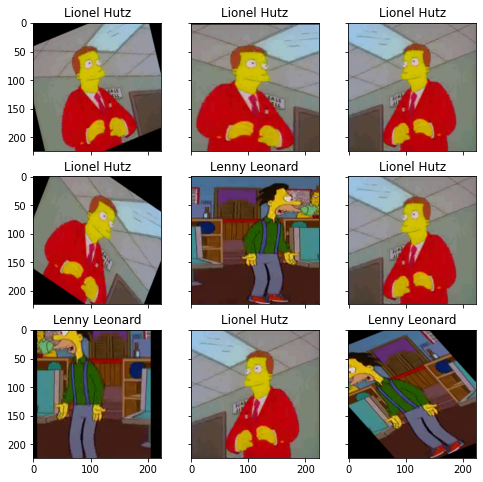

In [17]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(8, 8),
                       sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(8038, 8040))
    im_train, label = train_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),
                             train_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_train.data.cpu(),
           title=img_label, plt_ax=fig_x)

Видим, что созданные нами аугментации картинок рабботают нормально.

In [18]:
train_labels = [path.parent.name for path in train_files] 
val_labels = [path.parent.name for path in val_files]

In [19]:
len(val_labels), len(train_labels)

(5234, 15699)

Посмотрим, присутствует ли дисбаланс классов. 

In [20]:
data = pd.Series(train_val_labels).value_counts().sort_values().to_frame("count")
data

,count
lionel_hutz,3
troy_mcclure,8
disco_stu,8
miss_hoover,17
gil,27
fat_tony,27
otto_mann,32
sideshow_mel,40
agnes_skinner,42
rainier_wolfcastle,45


Да, сильный дисбаланс! 
Будем использовать WeightedRandomSampler для его устранения.

In [21]:
#для балансировки классов train
class_count = Counter(train_dataset.labels)
class_weights = {i: 1/c for i, c in class_count.items()}
sample_weights = [0] * len(train_dataset)
for i, (label) in enumerate(train_dataset.labels):
  class_weight = class_weights[label]
  sample_weights[i] = class_weight
N_train = max(class_count.values()) * len(class_count) 
train_sampler = WeightedRandomSampler(sample_weights, num_samples=N_train, replacement=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler, num_workers=N_CORES)

In [22]:
#для балансировки классов val
class_count = Counter(val_dataset.labels)
class_weights = {i: 1/c for i, c in class_count.items()}
sample_weights = [0] * len(val_dataset)
for i, (label) in enumerate(val_dataset.labels):
  class_weight = class_weights[label]
  sample_weights[i] = class_weight
N_val = max(class_count.values()) * len(class_count)
val_sampler = WeightedRandomSampler(sample_weights, num_samples=N_val, replacement=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, sampler=val_sampler, num_workers=N_CORES)

In [23]:
'''count = Counter()
for data, labels in tqdm(train_loader):
      count += Counter(labels.tolist())
print(sum(count.values()), count)'''

'count = Counter()\nfor data, labels in tqdm(train_loader):\n      count += Counter(labels.tolist())\nprint(sum(count.values()), count)'

In [24]:
'''count_val = Counter()
for data, labels in tqdm(val_loader):
      count_val += Counter(labels.tolist())
print(sum(count_val.values()), count_val)'''

'count_val = Counter()\nfor data, labels in tqdm(val_loader):\n      count_val += Counter(labels.tolist())\nprint(sum(count_val.values()), count_val)'

Давайте посмотрим на наших героев внутри датасета.

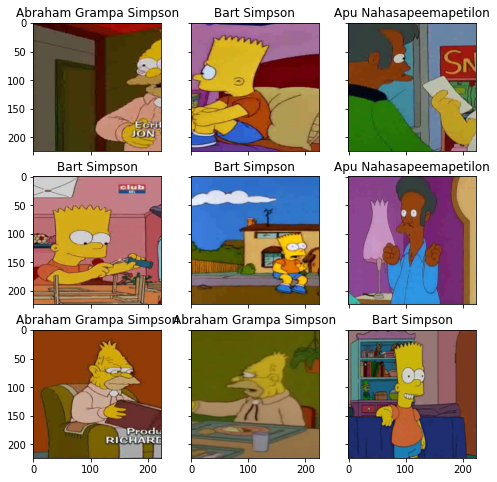

In [25]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение нейросети Simple CNN + FC +аугментация



In [26]:
n_classes = len(np.unique(train_val_labels))

Посмотрим на простую архитектуру сети CNN.

In [27]:
model = nn.Sequential(
    nn.Sequential(
        nn.Conv2d(3, 8, kernel_size=3, padding = 1),
        nn.BatchNorm2d(8),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(8, 16, kernel_size=3, padding = 1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=3, padding = 1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, padding = 1),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Sequential(
        nn.Conv2d(64, 96, kernel_size=3, padding = 1),
        nn.BatchNorm2d(96),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
    ),
    nn.Flatten(),
    nn.Linear(in_features=96*7*7, out_features=n_classes),
).to(DEVICE)
print("We will classify {} classes".format(n_classes))
print(f"Model: {model}")

We will classify 42 classes
Model: Sequential(
  (0): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  

In [30]:
def fit_epoch(model, train_loader, criterion, optimizer, sheduler=None): 
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    model.train(True) 
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()
        #print(inputs)
        #print(labels)
        #print(labels.data)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    if sheduler is not None: 
        sheduler.step() 
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [31]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [32]:
# обучение модели 
def train(train_loader, val_loader, model, criterion, optimizer, scheduler, epochs, batch_size):

    #train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    #val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    best_model_wts = model.state_dict() 
    best_acc = 0.0 

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    
    

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer, scheduler)
            #print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            if val_acc > best_acc:  
                best_acc = val_acc 
                best_model_wts = model.state_dict() 
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    print('Best val Acc: {:4f}'.format(best_acc)) 
    model.load_state_dict(best_model_wts) 
            
    #return history
    return model, history

In [33]:
# предсказание модели
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Изменим последний слой модели CNN, а также добавим еще один линейный слой с активацией ReLu

In [34]:
model[6] = nn.Sequential(
    nn.Linear(in_features=96*7*7, out_features=8192, bias=True),
    nn.ReLU(inplace=True))
    
model.append(nn.Sequential(
    nn.Linear(in_features=8192, out_features=8192, bias=True),
    nn.ReLU(inplace=True),
))

model.append(nn.Linear(in_features=8192, out_features=n_classes, bias=True))

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, m

In [35]:
model = model.to(DEVICE)
criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.2) #label_smoothing=0.8
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [36]:
model, history = train(train_loader, val_loader, model=model, criterion=criterion, optimizer=optimizer, scheduler=scheduler, epochs=20, batch_size=BATCH_SIZE)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 1.998502956339035


epoch:   5%|▌         | 1/20 [09:05<2:52:47, 545.65s/it]


Epoch 001 train_loss: 1.9985     val_loss 2.1257 train_acc 0.7395 val_acc 0.7037
loss 1.504490305403619


epoch:  10%|█         | 2/20 [17:47<2:39:31, 531.76s/it]


Epoch 002 train_loss: 1.5045     val_loss 2.0251 train_acc 0.9274 val_acc 0.7322
loss 1.3972206040214001


epoch:  15%|█▌        | 3/20 [26:26<2:29:00, 525.91s/it]


Epoch 003 train_loss: 1.3972     val_loss 1.9462 train_acc 0.9612 val_acc 0.7596
loss 1.33899604764517


epoch:  20%|██        | 4/20 [35:24<2:21:27, 530.44s/it]


Epoch 004 train_loss: 1.3390     val_loss 1.9279 train_acc 0.9786 val_acc 0.7614
loss 1.3053063586237958


epoch:  25%|██▌       | 5/20 [44:12<2:12:28, 529.88s/it]


Epoch 005 train_loss: 1.3053     val_loss 1.8874 train_acc 0.9876 val_acc 0.7750
loss 1.2856328188732542


epoch:  30%|███       | 6/20 [52:48<2:02:30, 525.04s/it]


Epoch 006 train_loss: 1.2856     val_loss 1.8985 train_acc 0.9924 val_acc 0.7765
loss 1.271101376344521


epoch:  35%|███▌      | 7/20 [1:01:22<1:52:56, 521.25s/it]


Epoch 007 train_loss: 1.2711     val_loss 1.8499 train_acc 0.9954 val_acc 0.7800
loss 1.2556663396441818


epoch:  40%|████      | 8/20 [1:09:53<1:43:39, 518.28s/it]


Epoch 008 train_loss: 1.2557     val_loss 1.8568 train_acc 0.9969 val_acc 0.7800
loss 1.2503775840781284


epoch:  45%|████▌     | 9/20 [1:18:23<1:34:30, 515.48s/it]


Epoch 009 train_loss: 1.2504     val_loss 1.8532 train_acc 0.9983 val_acc 0.7834
loss 1.249110167631398


epoch:  50%|█████     | 10/20 [1:26:52<1:25:36, 513.68s/it]


Epoch 010 train_loss: 1.2491     val_loss 1.8528 train_acc 0.9982 val_acc 0.7855
loss 1.2473728809538989


epoch:  55%|█████▌    | 11/20 [1:35:22<1:16:52, 512.46s/it]


Epoch 011 train_loss: 1.2474     val_loss 1.8391 train_acc 0.9984 val_acc 0.7972
loss 1.2457998685202518


epoch:  60%|██████    | 12/20 [1:43:51<1:08:11, 511.38s/it]


Epoch 012 train_loss: 1.2458     val_loss 1.8482 train_acc 0.9986 val_acc 0.7919
loss 1.2451500698878557


epoch:  65%|██████▌   | 13/20 [1:52:20<59:34, 510.63s/it]


Epoch 013 train_loss: 1.2452     val_loss 1.8417 train_acc 0.9985 val_acc 0.7913
loss 1.2440906616374252


epoch:  70%|███████   | 14/20 [2:00:50<51:02, 510.41s/it]


Epoch 014 train_loss: 1.2441     val_loss 1.8403 train_acc 0.9987 val_acc 0.7939
loss 1.243685846185269


epoch:  75%|███████▌  | 15/20 [2:09:19<42:30, 510.19s/it]


Epoch 015 train_loss: 1.2437     val_loss 1.8412 train_acc 0.9988 val_acc 0.7932
loss 1.2434921948541116


epoch:  80%|████████  | 16/20 [2:17:45<33:54, 508.73s/it]


Epoch 016 train_loss: 1.2435     val_loss 1.8314 train_acc 0.9989 val_acc 0.7910
loss 1.2429971796882975


epoch:  85%|████████▌ | 17/20 [2:26:13<25:25, 508.56s/it]


Epoch 017 train_loss: 1.2430     val_loss 1.8404 train_acc 0.9990 val_acc 0.7893
loss 1.2429624063614577


epoch:  90%|█████████ | 18/20 [2:34:40<16:56, 508.12s/it]


Epoch 018 train_loss: 1.2430     val_loss 1.8396 train_acc 0.9991 val_acc 0.7947
loss 1.2428313987770983


epoch:  95%|█████████▌| 19/20 [2:43:08<08:28, 508.06s/it]


Epoch 019 train_loss: 1.2428     val_loss 1.8362 train_acc 0.9989 val_acc 0.7928
loss 1.2424773669946707


epoch: 100%|██████████| 20/20 [2:51:37<00:00, 514.88s/it]


Epoch 020 train_loss: 1.2425     val_loss 1.8379 train_acc 0.9991 val_acc 0.7930
Best val Acc: 0.797238


In [38]:
loss, acc, val_loss, val_acc = zip(*history)

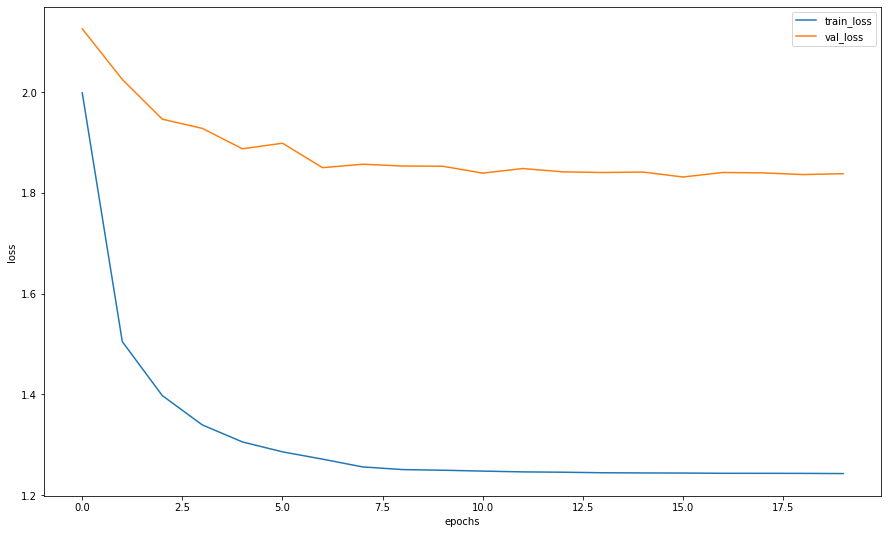

In [39]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Проверка

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [40]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [41]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model, ex_img.unsqueeze(0))

In [42]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model, imgs)

In [43]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [44]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [45]:
y_pred 

array([ 3,  4,  4, 20, 25,  6,  2,  0,  0,  0,  4, 15, 32,  6,  3, 15,  0,
        0,  4,  4])

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

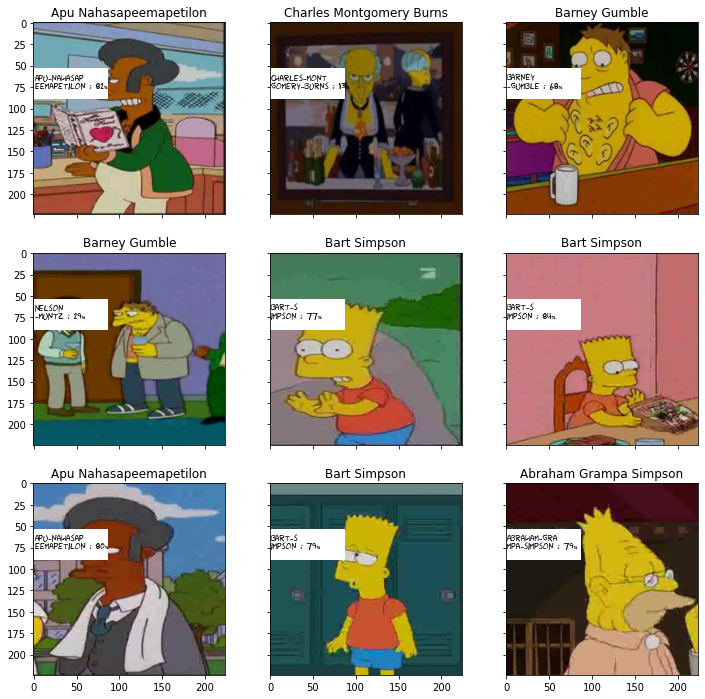

In [47]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Submit на Kaggle

In [48]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)

label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [49]:
! ls 

gdrive	label_encoder.pkl  sample_data	test  train


In [50]:
import pandas as pd
#my_submit = pd.read_csv("gdrive/My Drive/simpsons/data/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [51]:
my_submit.to_csv('gdrive/My Drive/Simpsons_kaggle/simple_cnn_fc_1.csv', index=False)

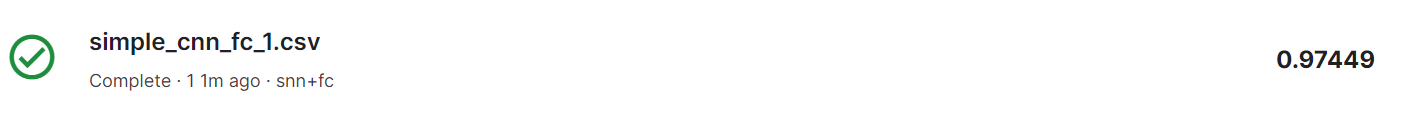

**ВЫВОД**:
Видим, что прикрутка всего одного дополнительного полносвязного линейного слоя к базовой модели, и, конечно же, борьба с дисбалансом классов, дали хороший прирост и требуемую оценку на Kaggle: 0.97449.